In [31]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from radiomics import featureextractor, getTestCase

In [2]:
image_viewer = sitk.ImageViewer()

In [3]:
#slicer = 'D:/Users/maryskal/Slicer 5.0.2/Slicer.exe'
slicer = '/home/maryskal/Slicer/Slicer'
image_viewer.SetApplication(slicer)

In [196]:
ctFolder = 'Vessel_stencils'
ctPath = os.path.join(ctFolder,'10047G_INSP_STD_BWH_COPD.nrrd')
maskPaths = ['mask__lt5_artery_2.nrrd', 'mask__lt5_artery_5.nrrd', 'mask_full_artery_3.nrrd']
maskPaths = [os.path.join(ctFolder, '10047G_INSP_STD_BWH_COPD', mask) for mask in maskPaths]

In [197]:
ct = sitk.ReadImage(ctPath)
masks = {}
for maskPath in maskPaths:
    masks[maskPath[-18:-5]] = sitk.ReadImage(maskPath)

In [198]:
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
extractor.enableFeatureClassByName('glrlm')
extractor.enableFeatureClassByName('ngtdm')
extractor.enabledFeatures

{'firstorder': [], 'glrlm': [], 'ngtdm': []}

### Extracción

In [199]:
features_dict = {}
for k, mask in masks.items():
    result = extractor.execute(ct, mask)
    feature_names = list(sorted(filter(lambda k: k.startswith("original_"), result)))
    features_dict[k] = {}
    for feature in feature_names:
        features_dict[k][feature] = float(result[feature])

In [201]:
features_dict

{'_lt5_artery_2': {'original_firstorder_10Percentile': -935.0,
  'original_firstorder_90Percentile': -743.0,
  'original_firstorder_Energy': 2213817577658.0,
  'original_firstorder_Entropy': 3.566112749855674,
  'original_firstorder_InterquartileRange': 86.0,
  'original_firstorder_Kurtosis': 19.30351857939092,
  'original_firstorder_Maximum': 847.0,
  'original_firstorder_Mean': -850.9562334521322,
  'original_firstorder_MeanAbsoluteDeviation': 67.74334782786221,
  'original_firstorder_Median': -878.0,
  'original_firstorder_Minimum': -1024.0,
  'original_firstorder_Range': 1871.0,
  'original_firstorder_RobustMeanAbsoluteDeviation': 37.953193368586334,
  'original_firstorder_RootMeanSquared': 857.307421089538,
  'original_firstorder_Skewness': 3.1342452630669175,
  'original_firstorder_TotalEnergy': 426998651400.7287,
  'original_firstorder_Uniformity': 0.11587951014855137,
  'original_firstorder_Variance': 10849.503004154827,
  'original_glrlm_GrayLevelNonUniformity': 272047.6493967

Union de los dos resultados

In [202]:
# lista de cada uno de los diccionarios
dict_list = [features for features in features_dict.values()]
# unifico los diccionarios (mismas claves, lista de valores)
features = {}
for k, v in dict_list[0].items():
    features[k] = [dic[k] for dic in dict_list]

In [203]:
df = pd.DataFrame(features)
# NORMALIZO
for column in df.columns:
    df[column] = abs(df[column] /df[column].abs().max())
# Añado la mascara
df['type_mask'] = masks.keys()

In [204]:
df

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,type_mask
0,0.993624,0.935768,0.200289,1.000000,1.000000,0.530287,0.658631,0.981902,1.000000,0.983203,...,0.418672,1.000000,1.000000,0.941028,0.273056,1.000000,0.823130,1.000000,1.000000,_lt5_artery_2
1,0.998937,1.000000,1.000000,0.917853,0.720930,1.000000,1.000000,1.000000,0.917719,1.000000,...,1.000000,0.905214,0.982390,0.962689,1.000000,0.226202,1.000000,0.587823,0.637996,_lt5_artery_5
2,1.000000,0.977330,0.444215,0.949444,0.802326,0.780372,0.661742,0.997269,0.936591,0.997760,...,0.726155,0.938933,0.940617,1.000000,0.562332,0.499863,0.715414,0.843726,0.654935,full_artery_3


In [164]:
firstorder = [col for col in df.columns if bool(re.search('firstorder', col))]
glrlm = [col for col in df.columns if bool(re.search('glrlm', col))]
ngtdm = [col for col in df.columns if bool(re.search('ngtdm', col))]

In [195]:
list(masks.keys())

['_lt5_artery_2',
 '_lt5_artery_3',
 '_lt5_artery_5',
 'full_artery_3',
 'k_full_vein_3']

## First order comparation

_lt5_artery_2
_lt5_artery_5
full_artery_3


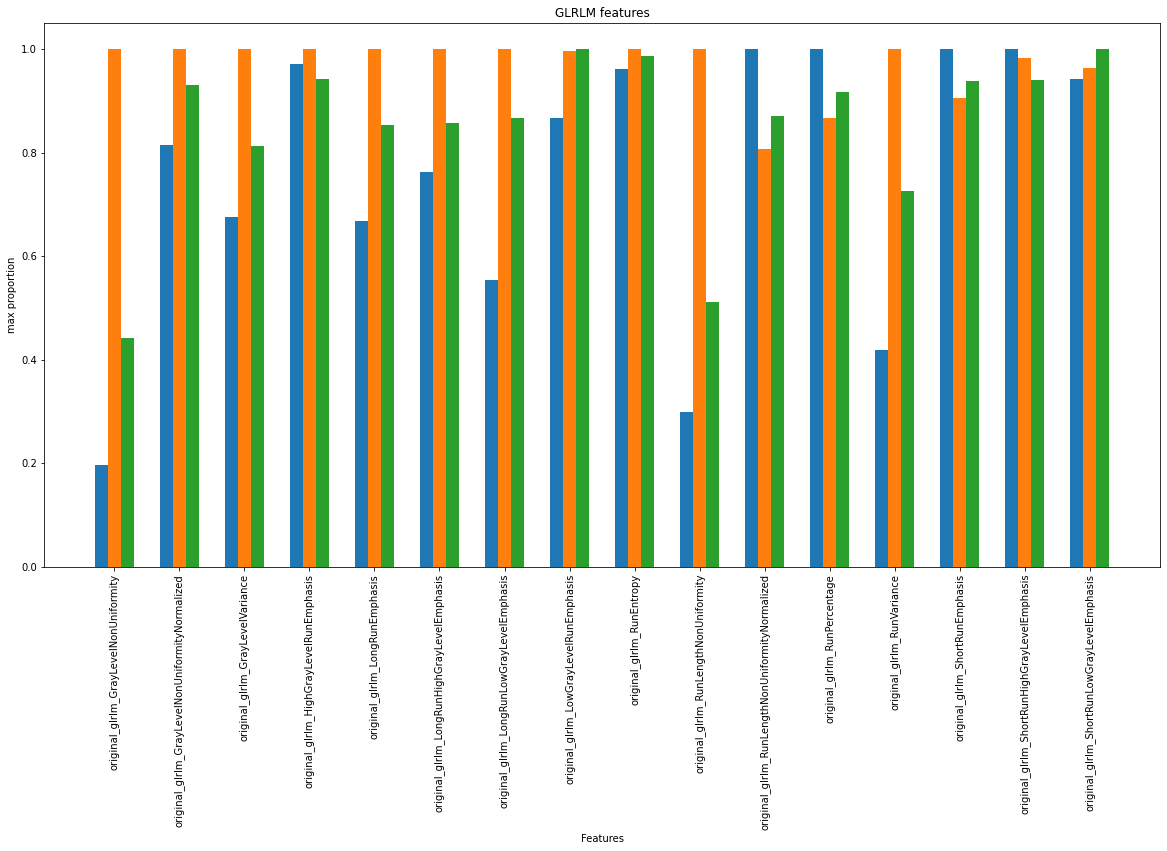

In [216]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

X = glrlm
X_axis = np.arange(len(X))
axis = [-0.2,0, 0.2]

for i in range(3):
    print(list(masks.keys())[i])
    plt.bar(X_axis+axis[i], df[glrlm].iloc[i], 0.2, label = list(masks.keys())[i])

plt.xticks(X_axis, X)
plt.xlabel("Features")
plt.ylabel("max proportion")
plt.title("GLRLM features")
plt.show()

## GLRLM comparation

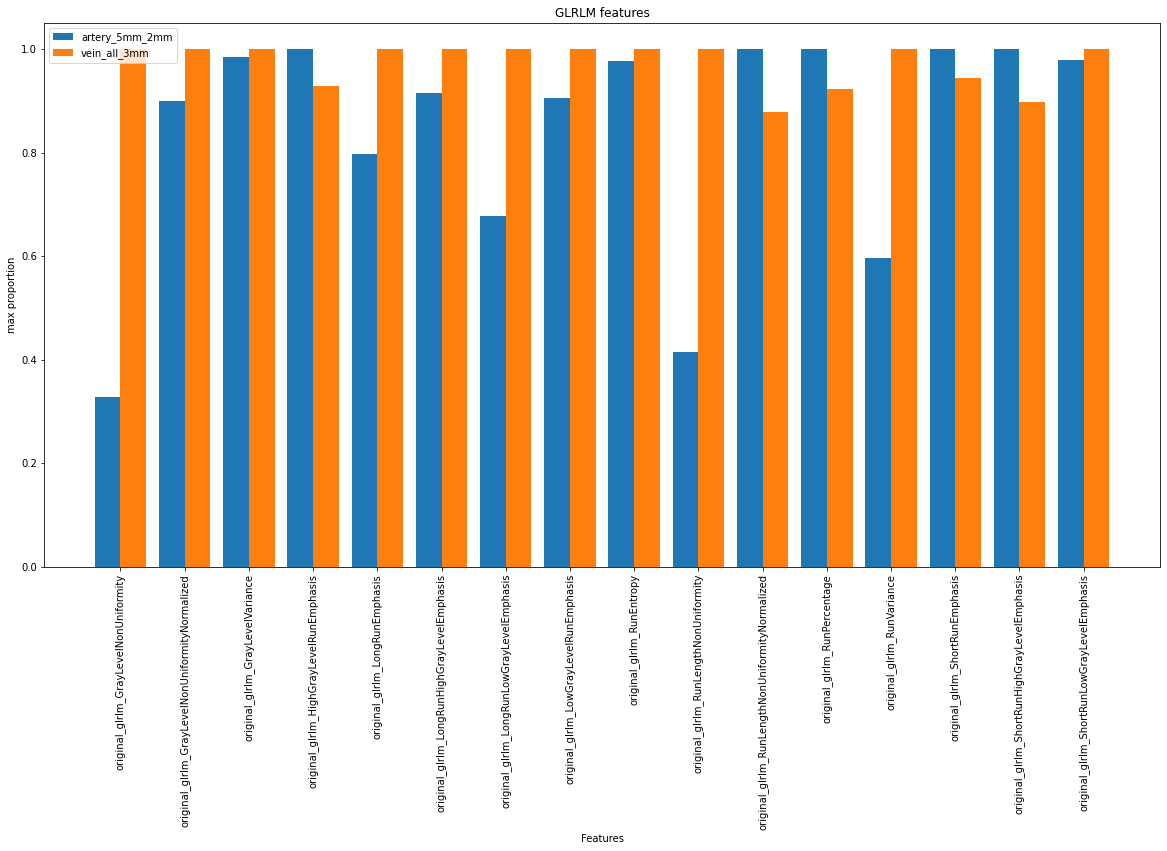

In [144]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

X = glrlm
A = df[glrlm].iloc[0]
B = df[glrlm].iloc[1]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, A, 0.4, label = 'artery_5mm_2mm')
plt.bar(X_axis + 0.2, B, 0.4, label = 'vein_all_3mm')
  
plt.xticks(X_axis, X)
plt.xlabel("Features")
plt.ylabel("max proportion")
plt.title("GLRLM features")
plt.legend()
plt.show()

## NGTDM comparation

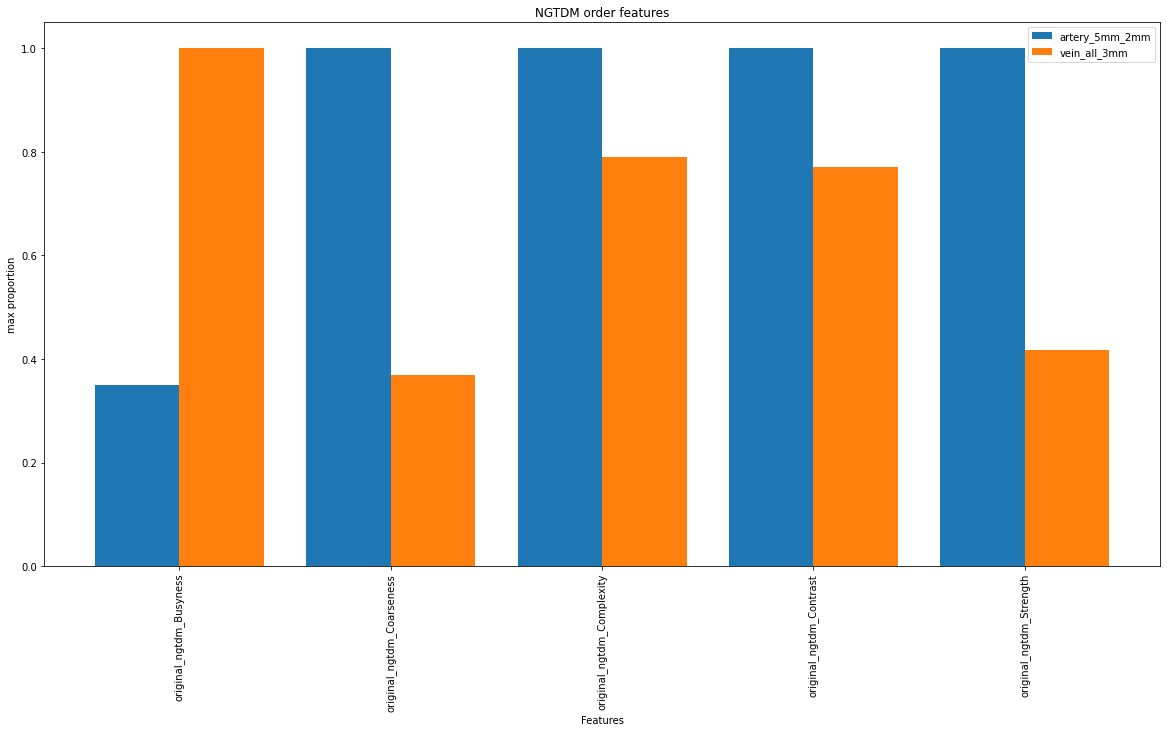

In [145]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

X = ngtdm
A = df[ngtdm].iloc[0]
B = df[ngtdm].iloc[1]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, A, 0.4, label = 'artery_5mm_2mm')
plt.bar(X_axis + 0.2, B, 0.4, label = 'vein_all_3mm')
  
plt.xticks(X_axis, X)
plt.xlabel("Features")
plt.ylabel("max proportion")
plt.title("NGTDM order features")
plt.legend()
plt.show()